# This notebook is to generate graphs for illustrating the methodologies, as well as some statistical analysis of the paper.

## Image Straightening algothrim flow

In [ ]:
# import os
# import subprocess

# os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

# def check_graphviz():
#     try:
#         subprocess.run(['dot', '-v'], check=True, capture_output=True, text=True)
#         print("Graphviz is correctly installed and accessible.")
#     except FileNotFoundError:
#         print("Graphviz is not found in the system PATH.")
#         print("Current PATH:", os.environ.get('PATH'))

# check_graphviz()

## Create a graph to illustrate the idea of "segmentation" and "keypoints" for sample image

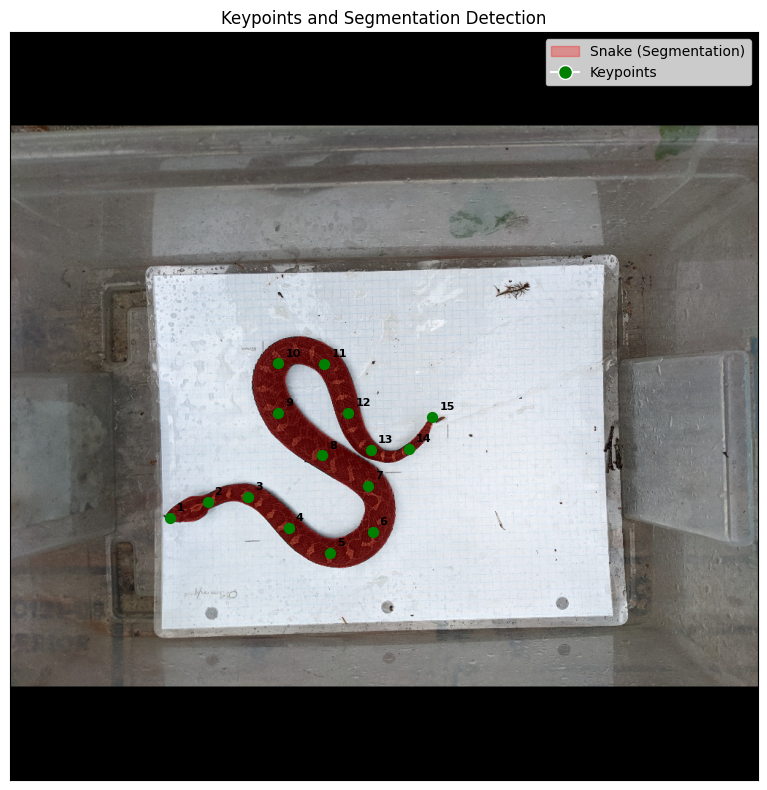

<Figure size 640x480 with 0 Axes>

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pycocotools import mask as mask_utils
from matplotlib.patches import Patch

def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def find_annotation(coco_data, image_filename):
    image_id = None
    for image in coco_data['images']:
        if image['file_name'] == image_filename:
            image_id = image['id']
            break
    
    if image_id is None:
        return None
    
    for annotation in coco_data['annotations']:
        if annotation['image_id'] == image_id:
            return annotation
    
    return None

def draw_keypoints_and_segmentation(image_path, coco_json_path):
    # Load COCO JSON
    coco_data = load_coco_json(coco_json_path)
    
    # Get image filename
    image_filename = image_path.split('\\')[-1]
    
    # Find annotation for the image
    annotation = find_annotation(coco_data, image_filename)
    
    if annotation is None:
        print(f"No annotation found for image: {image_filename}")
        return
    
    # Load image
    image = Image.open(image_path)
    image_array = np.array(image)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Display image
    ax.imshow(image_array)
    
    # Decode and draw segmentation
    rle = annotation['segmentation']
    mask = mask_utils.decode(rle)
    
    # Create a semi-transparent overlay for the segmentation
    overlay = np.zeros((*mask.shape, 4))
    overlay[mask == 1] = [1, 0, 0, 0.3]  # Red with 30% opacity
    
    ax.imshow(overlay)
    
    # Draw keypoints
    keypoints = np.array(annotation['keypoints']).reshape(-1, 3)
    visible_keypoints = keypoints[keypoints[:, 2] > 0]
    
    # Select 15 evenly spaced keypoints
    num_keypoints = min(15, len(visible_keypoints))
    selected_indices = np.linspace(0, len(visible_keypoints) - 1, num_keypoints, dtype=int)
    selected_keypoints = visible_keypoints[selected_indices]
    
    ax.scatter(selected_keypoints[:, 0], selected_keypoints[:, 1], 
               c='g', s=50, marker='o', label='Keypoints')
    
    # Label the keypoints with black numbers
    for i, (x, y, _) in enumerate(selected_keypoints):
        ax.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                    color='black', fontweight='bold', fontsize=8)
    
    # Create custom legend
    legend_elements = [
        Patch(facecolor='red', edgecolor='red', alpha=0.3, label='Snake (Segmentation)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Keypoints')
    ]
    
    # Add legend
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Set title
    ax.set_title(f"Keypoints and Segmentation Detection")
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Use the function
image_path = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\ariel_01_(40)_136.jpg'
coco_json_path = r'D:\Personal_Project\snake_straightening\data\isIDD_v2\label\all_1024\all_annotations_easy_1024.json'

draw_keypoints_and_segmentation(image_path, coco_json_path)

# save the plot
output_folder = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\straightening'
output_path = os.path.join(output_folder, 'keypoints_and_segmentation.png')
plt.savefig(output_path)

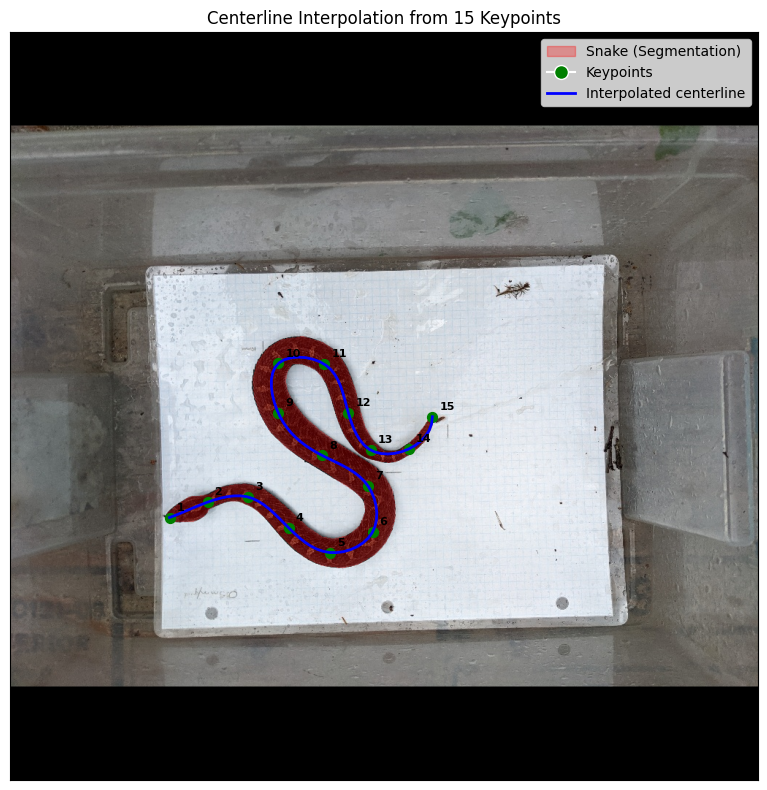

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pycocotools import mask as mask_utils
from matplotlib.patches import Patch
from scipy.interpolate import splprep, splev

def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def find_annotation(coco_data, image_filename):
    image_id = None
    for image in coco_data['images']:
        if image['file_name'] == image_filename:
            image_id = image['id']
            break
    
    if image_id is None:
        return None
    
    for annotation in coco_data['annotations']:
        if annotation['image_id'] == image_id:
            return annotation
    
    return None

def draw_keypoints_segmentation_and_centerline(image_path, coco_json_path):
    # Load COCO JSON
    coco_data = load_coco_json(coco_json_path)
    
    # Get image filename
    image_filename = image_path.split('\\')[-1]
    
    # Find annotation for the image
    annotation = find_annotation(coco_data, image_filename)
    
    if annotation is None:
        print(f"No annotation found for image: {image_filename}")
        return
    
    # Load image
    image = Image.open(image_path)
    image_array = np.array(image)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Display image
    ax.imshow(image_array)
    
    # Decode and draw segmentation
    rle = annotation['segmentation']
    mask = mask_utils.decode(rle)
    
    # Create a semi-transparent overlay for the segmentation
    overlay = np.zeros((*mask.shape, 4))
    overlay[mask == 1] = [1, 0, 0, 0.3]  # Red with 30% opacity
    
    ax.imshow(overlay)
    
    # Draw keypoints
    keypoints = np.array(annotation['keypoints']).reshape(-1, 3)
    visible_keypoints = keypoints[keypoints[:, 2] > 0]
    
    # Select 15 evenly spaced keypoints
    num_keypoints = min(15, len(visible_keypoints))
    selected_indices = np.linspace(0, len(visible_keypoints) - 1, num_keypoints, dtype=int)
    selected_keypoints = visible_keypoints[selected_indices]
    
    ax.scatter(selected_keypoints[:, 0], selected_keypoints[:, 1], 
               c='g', s=50, marker='o', label='Keypoints')
    
    # Label the keypoints with black numbers
    for i, (x, y, _) in enumerate(selected_keypoints):
        ax.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                    color='black', fontweight='bold', fontsize=8)
    
    # Interpolate centerline
    if len(selected_keypoints) > 3:  # Need at least 4 points for a smooth interpolation
        tck, u = splprep([selected_keypoints[:, 0], selected_keypoints[:, 1]], s=0, k=3)
        unew = np.linspace(0, 1, 100)
        interpolated_x, interpolated_y = splev(unew, tck)
        
        # Plot interpolated centerline
        ax.plot(interpolated_x, interpolated_y, 'b-', linewidth=2, label='Interpolated centerline')
    
    # Create custom legend
    legend_elements = [
        Patch(facecolor='red', edgecolor='red', alpha=0.3, label='Snake (Segmentation)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Keypoints'),
        plt.Line2D([0], [0], color='b', linewidth=2, label='Interpolated centerline')
    ]
    
    # Add legend
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Set title
    ax.set_title("Centerline Interpolation from 15 Keypoints")
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Use the function
image_path = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\ariel_01_(40)_136.jpg'
coco_json_path = r'D:\Personal_Project\snake_straightening\data\isIDD_v2\label\all_1024\all_annotations_easy_1024.json'

draw_keypoints_segmentation_and_centerline(image_path, coco_json_path)

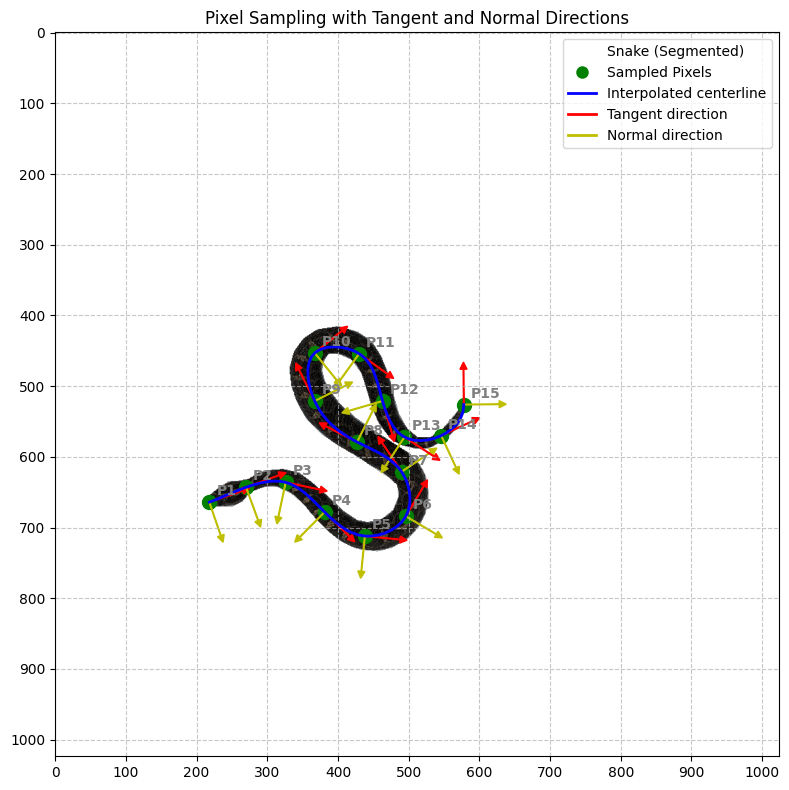

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pycocotools import mask as mask_utils
from matplotlib.patches import Patch
from scipy.interpolate import splprep, splev

def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def find_annotation(coco_data, image_filename):
    image_id = None
    for image in coco_data['images']:
        if image['file_name'] == image_filename:
            image_id = image['id']
            break
    
    if image_id is None:
        return None
    
    for annotation in coco_data['annotations']:
        if annotation['image_id'] == image_id:
            return annotation
    
    return None

def draw_pixel_sampling(image_path, coco_json_path):
    # Load COCO JSON
    coco_data = load_coco_json(coco_json_path)
    
    # Get image filename
    image_filename = image_path.split('\\')[-1]
    
    # Find annotation for the image
    annotation = find_annotation(coco_data, image_filename)
    
    if annotation is None:
        print(f"No annotation found for image: {image_filename}")
        return
    
    # Load image
    image = Image.open(image_path)
    image_array = np.array(image)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Decode segmentation
    rle = annotation['segmentation']
    mask = mask_utils.decode(rle)
    
    # Create a new RGBA image with transparency
    rgba_image = np.zeros((image_array.shape[0], image_array.shape[1], 4), dtype=np.uint8)
    rgba_image[:,:,:3] = image_array
    rgba_image[:,:,3] = 255  # Fully opaque
    
    # Apply mask to image
    rgba_image[mask == 0] = [0, 0, 0, 0]  # Set non-snake pixels to transparent
    
    # Display masked image
    ax.imshow(rgba_image)
    
    # Draw keypoints
    keypoints = np.array(annotation['keypoints']).reshape(-1, 3)
    visible_keypoints = keypoints[keypoints[:, 2] > 0]
    
    # Select 15 evenly spaced keypoints
    num_keypoints = min(15, len(visible_keypoints))
    selected_indices = np.linspace(0, len(visible_keypoints) - 1, num_keypoints, dtype=int)
    selected_keypoints = visible_keypoints[selected_indices]
    
    ax.scatter(selected_keypoints[:, 0], selected_keypoints[:, 1], 
               c='g', s=100, marker='o', label='Sampled Pixels')
    
    # Interpolate centerline
    if len(selected_keypoints) > 3:  # Need at least 4 points for a smooth interpolation
        tck, u = splprep([selected_keypoints[:, 0], selected_keypoints[:, 1]], s=0, k=3)
        unew = np.linspace(0, 1, 100)
        interpolated_x, interpolated_y = splev(unew, tck)
        
        # Plot interpolated centerline
        ax.plot(interpolated_x, interpolated_y, 'b-', linewidth=2, label='Interpolated centerline')
        
        # Calculate tangent and normal vectors
        dx, dy = splev(unew, tck, der=1)
        
        # Draw tangent and normal vectors at sampled points
        for i, (x, y, _) in enumerate(selected_keypoints):
            # Find the closest point on the interpolated curve
            dist = np.sqrt((interpolated_x - x)**2 + (interpolated_y - y)**2)
            idx = np.argmin(dist)
            
            # Tangent vector
            tx, ty = dx[idx], dy[idx]
            length = np.sqrt(tx**2 + ty**2)
            tx, ty = tx/length * 50, ty/length * 50  # Scale to fixed length
            ax.arrow(x, y, tx, ty, color='r', width=1, head_width=10, head_length=10, label='Tangent' if i == 0 else "")
            
            # Normal vector (perpendicular to tangent)
            nx, ny = -ty, tx
            ax.arrow(x, y, nx, ny, color='y', width=1, head_width=10, head_length=10, label='Normal' if i == 0 else "")
            
            # Label the sampled pixels
            ax.annotate(f'P{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', color='grey', fontweight='bold')
    
    # Add grid lines
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Create custom legend
    legend_elements = [
        Patch(facecolor='none', edgecolor='white', label='Snake (Segmented)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Sampled Pixels'),
        plt.Line2D([0], [0], color='b', linewidth=2, label='Interpolated centerline'),
        plt.Line2D([0], [0], color='r', linewidth=2, label='Tangent direction'),
        plt.Line2D([0], [0], color='y', linewidth=2, label='Normal direction')
    ]
    
    # Add legend
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Set title
    ax.set_title("Pixel Sampling with Tangent and Normal Directions")
    
    # Show x and y axis ticks
    ax.set_xticks(np.arange(0, image_array.shape[1], 100))
    ax.set_yticks(np.arange(0, image_array.shape[0], 100))
    ax.set_xticklabels(np.arange(0, image_array.shape[1], 100))
    ax.set_yticklabels(np.arange(0, image_array.shape[0], 100))
    
    # Show plot
    plt.tight_layout()
    plt.show()

draw_pixel_sampling(image_path, coco_json_path)

C:\Users\kwokt\AppData\Local\Temp\ipykernel_20232\2111531574.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


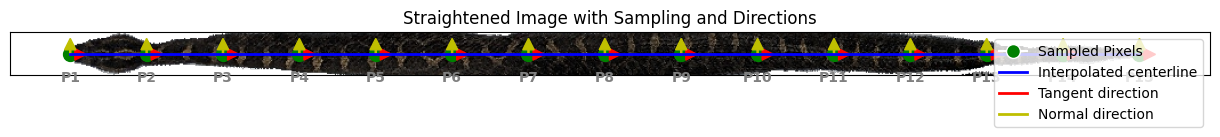

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pycocotools import mask as mask_utils
from matplotlib.patches import Patch
from scipy.interpolate import splprep, splev

output_folder = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\straightening'

def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def find_annotation(coco_data, image_filename):
    image_id = None
    for image in coco_data['images']:
        if image['file_name'] == image_filename:
            image_id = image['id']
            break
    
    if image_id is None:
        return None
    
    for annotation in coco_data['annotations']:
        if annotation['image_id'] == image_id:
            return annotation
    
    return None

def draw_straightened_image(straightened_image_path, num_points=15, output_folder='.'):
    # Load straightened image
    straightened_image = Image.open(straightened_image_path)
    straightened_array = np.array(straightened_image)
    
    # Create figure and axes with the same aspect ratio as the image
    height, width = straightened_array.shape[:2]
    fig, ax = plt.subplots(figsize=(12, 12 * height / width))
    
    # Display straightened image
    ax.imshow(straightened_array)
    
    # Create evenly spaced points along the centerline
    x_points = np.linspace(0, width - 1, num_points)
    y_points = np.full_like(x_points, height // 2)
    
    # Plot sample pixels
    ax.scatter(x_points, y_points, c='g', s=100, marker='o', label='Sampled Pixels')
    
    # Label the sampled pixels
    for i, (x, y) in enumerate(zip(x_points, y_points)):
        ax.annotate(f'P{i+1}', (x, y), xytext=(0, -20), textcoords='offset points', 
                    color='grey', fontweight='bold', ha='center')
    
    # Plot interpolated centerline
    ax.plot([0, width - 1], [height // 2, height // 2], 'b-', linewidth=2, label='Interpolated centerline')
    
    # Draw standardized tangent and normal vectors
    arrow_length = height // 8
    for x in x_points:
        # Tangent vector (pointing right)
        ax.arrow(x, height // 2, arrow_length, 0, color='r', width=1, head_width=10, head_length=10, 
                 label='Tangent' if x == x_points[0] else "")
        
        # Normal vector (pointing up)
        ax.arrow(x, height // 2, 0, -arrow_length, color='y', width=1, head_width=10, head_length=10, 
                 label='Normal' if x == x_points[0] else "")
    
    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Sampled Pixels'),
        plt.Line2D([0], [0], color='b', linewidth=2, label='Interpolated centerline'),
        plt.Line2D([0], [0], color='r', linewidth=2, label='Tangent direction'),
        plt.Line2D([0], [0], color='y', linewidth=2, label='Normal direction')
    ]
    
    # Add legend
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Set title
    ax.set_title("Straightened Image with Sampling and Directions")
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove extra white space
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # save the plot
    output_path = os.path.join(output_folder, 'straightened_image_sampling.png')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    
    # Show plot
    plt.show()
    
    # Close the figure to free up memory
    plt.close(fig)

# Use the function
straightened_image_path = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\straightening\ariel_01_(40)_136_straightened.png'
draw_straightened_image(straightened_image_path, output_folder=output_folder)

## Create necessary graphs for illustrating the idea of " Keypoint-guided orphedian transformation"

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Path to the COCO JSON file
coco_json_path = r'D:\Personal_Project\snake_straightening\data\isIDD_v2\label\all_1024\all_annotations_easy_1024.json'

# Read the JSON file
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

first_image = coco_data['images'][7]
image_id = first_image['id']
image_width = first_image['width']
image_height = first_image['height']

# Find the annotation for the first image
first_annotation = next(ann for ann in coco_data['annotations'] if ann['image_id'] == image_id)

# Extract keypoints
keypoints = first_annotation['keypoints']

# Reshape keypoints into (x, y, visibility) triples
keypoints = np.array(keypoints).reshape(-1, 3)

# Filter out invisible keypoints
visible_keypoints = keypoints[keypoints[:, 2] > 0]

# Select 15 equally distributed points
num_points = 15
if len(visible_keypoints) >= num_points:
    indices = np.linspace(0, len(visible_keypoints) - 1, num_points, dtype=int)
    selected_points = visible_keypoints[indices]
else:
    selected_points = visible_keypoints  # Use all points if less than 15

# Create a new figure
plt.figure(figsize=(12, 12))

# Plot keypoints
for i, (x, y, v) in enumerate(selected_points):
    plt.plot(x, y, 'ro', markersize=10)  # Red circle
    plt.text(x+5, y+5, str(i+1), fontsize=12, color='blue')  # Label each point

# Plot lines connecting the points
plt.plot(selected_points[:, 0], selected_points[:, 1], 'b-', linewidth=2, alpha=0.5)

# Set the limits of the plot to match the image dimensions
plt.xlim(0, image_width)
plt.ylim(image_height, 0)  # Reverse y-axis to match image coordinates

# Add title and labels
plt.title('Reference Keypoints', fontsize=16)

# Add grid for better visibility
plt.grid(True, linestyle='--', alpha=0.7)


# Save the plot
output_path = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\kgot\reference_keypoints.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Keypoints visualization saved as {output_path}")

Keypoints visualization saved as D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\kgot\reference_keypoints.png


In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np

def calculate_tangent_normal(points):
    tangents = np.zeros_like(points)
    normals = np.zeros_like(points)
    
    # Calculate tangents
    tangents[1:-1] = points[2:] - points[:-2]
    tangents[0] = points[1] - points[0]
    tangents[-1] = points[-1] - points[-2]
    
    # Normalize tangents
    tangents = tangents / np.linalg.norm(tangents, axis=1)[:, np.newaxis]
    
    # Calculate normals (rotate tangents by 90 degrees)
    normals[:, 0] = -tangents[:, 1]
    normals[:, 1] = tangents[:, 0]
    
    return tangents, normals

# Path to the COCO JSON file
coco_json_path = r'D:\Personal_Project\snake_straightening\data\isIDD_v2\label\all_1024\all_annotations_easy_1024.json'

# Read the JSON file
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Find the annotation for the first image
first_annotation = next(ann for ann in coco_data['annotations'] if ann['image_id'] == image_id)

# Extract keypoints
keypoints = np.array(first_annotation['keypoints']).reshape(-1, 3)

# Filter out invisible keypoints
visible_keypoints = keypoints[keypoints[:, 2] > 0][:, :2]  # Only x and y coordinates

# Select 15 equally distributed points
num_points = 15
if len(visible_keypoints) >= num_points:
    indices = np.linspace(0, len(visible_keypoints) - 1, num_points, dtype=int)
    selected_points = visible_keypoints[indices]
else:
    selected_points = visible_keypoints  # Use all points if less than 15

# Calculate tangents and normals
tangents, normals = calculate_tangent_normal(selected_points)

# Create a new figure
plt.figure(figsize=(12, 12))

# Plot smooth line connecting the points (blue)
plt.plot(selected_points[:, 0], selected_points[:, 1], 'b-', linewidth=2, alpha=0.7)

# Plot keypoints
for i, (x, y) in enumerate(selected_points):
    plt.plot(x, y, 'go', markersize=10)  # Green circle
    plt.text(x+5, y+5, str(i+1), fontsize=12, color='blue')  # Label each point

# Plot tangent and normal vectors
scale = 30  # Scale factor for vector visualization
for i, (point, tangent, normal) in enumerate(zip(selected_points, tangents, normals)):
    # Tangent vector (red)
    plt.arrow(point[0], point[1], tangent[0]*scale, tangent[1]*scale, 
              color='r', width=1, head_width=5, head_length=7, alpha=0.7)
    # Normal vector (yellow)
    plt.arrow(point[0], point[1], normal[0]*scale, normal[1]*scale, 
              color='y', width=1, head_width=5, head_length=7, alpha=0.7)

# Set the limits of the plot to match the image dimensions
plt.xlim(0, image_width)
plt.ylim(image_height, 0)  # Reverse y-axis to match image coordinates

# Add title and labels
plt.title('Reference Keypoints with Tangent and Normal Vectors', fontsize=16)
plt.xlabel('X coordinate', fontsize=12)
plt.ylabel('Y coordinate', fontsize=12)

# Add legend
plt.plot([], [], 'go', label='Keypoints', markersize=10)
plt.plot([], [], 'b-', label='Smooth line')
plt.plot([], [], 'r-', label='Tangent')
plt.plot([], [], 'y-', label='Normal')
plt.legend(fontsize=12)

# Add grid for better visibility
plt.grid(True, linestyle='--', alpha=0.7)

# Save the plot
output_path = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\kgot\reference_keypoints_with_tangent_normal.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Keypoints visualization with tangent and normal vectors saved as {output_path}")

Keypoints visualization with tangent and normal vectors saved as D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\kgot\reference_keypoints_with_tangent_normal.png


In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

def calculate_tangent_normal(points):
    tangents = np.zeros_like(points)
    normals = np.zeros_like(points)
    
    # Calculate tangents
    tangents[1:-1] = points[2:] - points[:-2]
    tangents[0] = points[1] - points[0]
    tangents[-1] = points[-1] - points[-2]
    
    # Normalize tangents
    tangents = tangents / np.linalg.norm(tangents, axis=1)[:, np.newaxis]
    
    # Calculate normals (rotate tangents by 90 degrees)
    normals[:, 0] = -tangents[:, 1]
    normals[:, 1] = tangents[:, 0]
    
    return tangents, normals

def generate_reference_curve(keypoints, num_points=1000, target_length=None):
    distances = np.linalg.norm(np.diff(keypoints, axis=0), axis=1)
    original_total_length = np.sum(distances)
    
    print(f"Original length: {original_total_length:.2f}")
    print(f"Target length: {target_length}")
    
    if target_length is not None:
        scale_factor = target_length / original_total_length
        scaled_distances = distances * scale_factor
        scaled_cumulative_distances = np.insert(np.cumsum(scaled_distances), 0, 0)
        
        scaled_keypoints = np.zeros_like(keypoints)
        scaled_keypoints[0] = keypoints[0]
        scaled_keypoints[1:] = keypoints[0] + np.cumsum(np.diff(keypoints, axis=0) * scale_factor, axis=0)
        
        t = np.linspace(0, 1, num_points)
        f = interp1d(scaled_cumulative_distances / scaled_cumulative_distances[-1], scaled_keypoints, axis=0, kind='linear')
        smooth_curve = f(t)
        
        sigma = 1 * scale_factor
        smooth_curve = gaussian_filter1d(smooth_curve, sigma, axis=0)
    else:
        scale_factor = 1
        smooth_curve = keypoints
    
    new_length = np.sum(np.linalg.norm(np.diff(smooth_curve, axis=0), axis=1))
    print(f"New length: {new_length:.2f}")
    print(f"Scale factor: {scale_factor:.2f}")
    
    return smooth_curve, scale_factor

# Path to the COCO JSON file
coco_json_path = r'D:\Personal_Project\snake_straightening\data\isIDD_v2\label\all_1024\all_annotations_easy_1024.json'

# Read the JSON file
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

first_image = coco_data['images'][7]
image_id = first_image['id']
image_width = first_image['width']
image_height = first_image['height']

# Find the annotation for the first image
first_annotation = next(ann for ann in coco_data['annotations'] if ann['image_id'] == image_id)

# Extract keypoints
keypoints = np.array(first_annotation['keypoints']).reshape(-1, 3)

# Filter out invisible keypoints
visible_keypoints = keypoints[keypoints[:, 2] > 0][:, :2]  # Only x and y coordinates

# Load the straightened image
image_path = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\straightening\ariel_01_(40)_136_straightened.png'
image = Image.open(image_path)
image_array = np.array(image)

# Generate the scaled reference curve
target_length = image_array.shape[1]  # Use the width of the loaded image
smooth_curve, scale_factor = generate_reference_curve(visible_keypoints, num_points=1000, target_length=target_length)

# Calculate tangents and normals for the smooth curve
tangents, normals = calculate_tangent_normal(smooth_curve)

# Create a new figure
plt.figure(figsize=(12, 12))

# Display the image
plt.imshow(image_array)

# Plot smooth curve (blue)
plt.plot(smooth_curve[:, 0], smooth_curve[:, 1], 'b-', linewidth=2, alpha=0.7)

# Select 15 equally distributed points along the smooth curve
num_sample_points = 15
sample_indices = np.linspace(0, len(smooth_curve) - 1, num_sample_points, dtype=int)
sampled_points = smooth_curve[sample_indices]

# Plot sampled points
for i, (x, y) in enumerate(sampled_points):
    plt.plot(x, y, 'go', markersize=10)  # Green circle
    plt.text(x+5, y+5, str(i+1), fontsize=12, color='white', fontweight='bold')  # Label each point

# Plot tangent and normal vectors for sampled points
scale = 30  # Scale factor for vector visualization
for point, tangent, normal in zip(sampled_points, tangents[sample_indices], normals[sample_indices]):
    # Tangent vector (red)
    plt.arrow(point[0], point[1], tangent[0]*scale, tangent[1]*scale, 
              color='r', width=1, head_width=5, head_length=7, alpha=0.7)
    # Normal vector (yellow)
    plt.arrow(point[0], point[1], normal[0]*scale, normal[1]*scale, 
              color='y', width=1, head_width=5, head_length=7, alpha=0.7)

# Set the limits of the plot to match the image dimensions
plt.xlim(0, image_array.shape[1])
plt.ylim(image_array.shape[0], 0)  # Reverse y-axis to match image coordinates

# Remove axis ticks
plt.xticks([])
plt.yticks([])

# Add title
plt.title('Straightened Image with Scaled Reference Curve, Tangent and Normal Vectors', fontsize=16)

# Add legend
plt.plot([], [], 'go', label='Sampled Points', markersize=10)
plt.plot([], [], 'b-', label='Scaled Reference Curve')
plt.plot([], [], 'r-', label='Tangent')
plt.plot([], [], 'y-', label='Normal')
plt.legend(fontsize=12, loc='upper right')

# Save the plot
output_path = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\straightening\straightened_image_with_scaled_reference_tangent_normal.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Straightened image visualization with scaled reference curve, tangent and normal vectors saved as {output_path}")

Original length: 1131.44
Target length: 938
New length: 937.09
Scale factor: 0.83
Straightened image visualization with scaled reference curve, tangent and normal vectors saved as D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\straightening\straightened_image_with_scaled_reference_tangent_normal.png


## Create a flowchart to illustrate the steps of preparing the necessary information required for KGOT:

In [2]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment='Flowchart')
dot.attr(rankdir='TB', size='12,12')  # Increased size for better spacing

# Define global graph attributes
dot.attr(fontsize='20', fontname = 'Arial')  # Increased global font size
dot.attr(rankdir='TB')
dot.attr(rank='same')
dot.attr(ranksep='1')
dot.attr(nodesep='1')

# Define node styles
dot.attr('node', shape='rectangle', style='rounded,filled', fillcolor='#FFCCCC', width='4', height='1.5', fontsize='20')
dot.node('start', 'Start')
dot.node('stop', 'End')

dot.attr('node', shape='rectangle', style='filled', fillcolor='#FFE5CC', width='4', height='1.5', fontsize='20')
dot.node('annotate', 'Annotate snake body\nsegmentation and keypoints')
dot.node('split', 'Split data into\ntrain, val, test sets')
dot.node('train', 'Train Models')
dot.node('select', 'Select best method')
dot.node('augment', 'Apply proposed\naugmentation algorithm')

dot.attr('node', shape='diamond', style='filled', fillcolor='#CCFFCC', width='4', height='2', fontsize='20')
dot.node('compare', 'Compare\nperformance')

# Create subgraph for model training
with dot.subgraph(name='cluster_0') as c:
    c.attr(label='Model Training', style='dashed', labelloc='t', fontsize='24')
    c.attr('node', shape='rectangle', style='filled', fillcolor='#FFE5CC', width='4', height='1.5', fontsize='20')
    c.node('mrcnn', 'MRCNN\n(Segmentation only)\n+ Medical Axis Extraction')
    c.node('yolo', 'YOLOv8\n(Segmentation only)\n+ Medical Axis Extraction')
    c.node('mrcnn_multi', 'MRCNN\n(Multitask)')
    c.attr(rank='same')

# Add edges
dot.edge('start', 'annotate')
dot.edge('annotate', 'split')
dot.edge('split', 'train')
dot.edge('train', 'mrcnn')
dot.edge('train', 'yolo')
dot.edge('train', 'mrcnn_multi')
dot.edge('mrcnn', 'compare')
dot.edge('yolo', 'compare')
dot.edge('mrcnn_multi', 'compare')
dot.edge('compare', 'select')
dot.edge('select', 'augment')
dot.edge('augment', 'stop')

# Center align the graph
dot.attr(layout='dot')

# Render the graph
dot.render('flowchart', format='png', cleanup=True)
print("Flowchart has been generated as 'flowchart_data_prep.png'")

Flowchart has been generated as 'flowchart_data_prep.png'


In [8]:
import json
import numpy as np
import cv2
from pycocotools import mask as mask_utils
from scipy.interpolate import interp1d
import os
from skimage.draw import line
import time

def divide_mask_by_centerline(mask, centerline, num_segments=10):
    start_time = time.time()
    
    # Ensure centerline is a numpy array
    centerline = np.array(centerline)

    # Interpolate the centerline to get more points
    t = np.linspace(0, 1, len(centerline))
    t_new = np.linspace(0, 1, num_segments * 10)
    f_x = interp1d(t, centerline[:, 0], kind='cubic')
    f_y = interp1d(t, centerline[:, 1], kind='cubic')
    centerline_interp = np.column_stack((f_x(t_new), f_y(t_new)))

    # Calculate tangent vectors along the centerline
    tangents = np.gradient(centerline_interp, axis=0)

    # Normalize tangent vectors
    tangents = tangents / np.linalg.norm(tangents, axis=1)[:, np.newaxis]

    # Calculate normal vectors (perpendicular to tangents)
    normals = np.column_stack((-tangents[:, 1], tangents[:, 0]))

    # Select evenly spaced points along the centerline
    indices = np.linspace(0, len(centerline_interp) - 1, num_segments + 1, dtype=int)
    selected_points = centerline_interp[indices]

    # Create a list to store the segment masks and dividing line coordinates
    segment_masks = []
    widths = []

    # Iterate through pairs of selected points to create segment masks
    for i in range(len(selected_points) - 1):
        start_point = selected_points[i]
        end_point = selected_points[i + 1]
        
        # Create a binary mask for the current segment
        segment_mask = np.zeros_like(mask, dtype=np.uint8)
        
        # Draw a line between the start and end points
        rr, cc = line(int(start_point[1]), int(start_point[0]), int(end_point[1]), int(end_point[0]))
        
        # Create perpendicular lines along the segment
        segment_widths = []
        for r, c in zip(rr, cc):
            normal = normals[indices[i]]
            width = 0
            for direction in [1, -1]:
                current_point = np.array([c, r], dtype=float)
                while True:
                    x, y = np.round(current_point).astype(int)
                    if x < 0 or x >= mask.shape[1] or y < 0 or y >= mask.shape[0] or mask[y, x] == 0:
                        break
                    segment_mask[y, x] = 255
                    current_point += direction * normal
                    width += 1
            segment_widths.append(width)
        
        widths.append(np.mean(segment_widths))
        segment_masks.append(segment_mask)

    end_time = time.time()
    print(f"Total process took {end_time - start_time:.2f} seconds")

    return segment_masks, widths

def straighten_images_from_coco(json_file_path, image_folder, output_folder):
    # 读入COCO JSON文件
    with open(json_file_path, 'r') as f:
        coco_data = json.load(f)

    # 创建输出文件夹（如果不存在）
    os.makedirs(output_folder, exist_ok=True)

    # 处理每个标注
    for ann in coco_data['annotations']:
        # 获取图像ID和文件名
        image_id = ann['image_id']
        image_info = next(img for img in coco_data['images'] if img['id'] == image_id)
        image_filename = image_info['file_name']

        # Read the original image
        image_path = os.path.join(image_folder, image_filename)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        # Convert image to RGBA if necessary
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
        elif image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)

        # 提取中心线关键点
        keypoints = np.array(ann['keypoints']).reshape(-1, 3)[:, :2]  # 只取x和y坐标

        # 解码RLE掩码
        rle = ann['segmentation']
        mask = mask_utils.decode(rle)

        # 使用divide_mask_by_centerline计算宽度
        _, widths = divide_mask_by_centerline(mask, keypoints)

        # 计算平均宽度
        avg_width = int(np.mean(widths))

        # 计算中心线的长度
        total_length = np.sum(np.sqrt(np.sum(np.diff(keypoints, axis=0)**2, axis=1)))

        # Straighten the image
        straightened = straighten_image(image, keypoints, mask, total_length, avg_width)

        # Save the straightened image as PNG with transparency (RGBA)
        output_filename = f"straightened_{os.path.splitext(image_filename)[0]}.png"
        output_path = os.path.join(output_folder, output_filename)
        
        # Convert RGBA to BGRA before saving
        straightened_bgra = cv2.cvtColor(straightened, cv2.COLOR_RGBA2BGRA)
        cv2.imwrite(output_path, straightened_bgra, [cv2.IMWRITE_PNG_COMPRESSION, 9])

        print(f"Processed and saved: {output_filename}")

def straighten_image(image, keypoints, mask, output_length, output_width):
    # Get image dimensions
    h, w = image.shape[:2]

    # Calculate output image height
    output_height = int(output_width * (h / w))

    # Create output image with alpha channel (RGBA)
    straightened = np.zeros((output_height, int(output_length), 4), dtype=np.uint8)

    # Convert input image to RGBA if it's not already
    if image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)

    # Create parameterized representation of the centerline
    t = np.linspace(0, 1, len(keypoints))

    # Create interpolation functions for x and y coordinates
    fx = interp1d(t, keypoints[:, 0], kind='linear', bounds_error=False, fill_value="extrapolate")
    fy = interp1d(t, keypoints[:, 1], kind='linear', bounds_error=False, fill_value="extrapolate")

    # Sample for each output pixel
    for i in range(int(output_length)):
        # Calculate current position parameter on the centerline
        param = i / (output_length - 1)

        # Get point on the centerline
        cx, cy = fx(param), fy(param)

        # Calculate tangent direction of the centerline
        delta = 0.01
        if param + delta > 1:
            prev_x, prev_y = fx(param - delta), fy(param - delta)
            dx, dy = cx - prev_x, cy - prev_y
        else:
            next_x, next_y = fx(param + delta), fy(param + delta)
            dx, dy = next_x - cx, next_y - cy

        # Normalize tangent vector
        length = np.sqrt(dx**2 + dy**2)
        dx, dy = dx / length, dy / length

        # Calculate normal direction
        nx, ny = -dy, dx

        # Sample in the direction perpendicular to the centerline
        for j in range(output_height):
            # Calculate sampling point
            offset = (j - output_height / 2)
            sx = int(cx + offset * nx)
            sy = int(cy + offset * ny)

            # Check if sampling point is within image bounds and inside the mask
            if 0 <= sx < w and 0 <= sy < h and mask[sy, sx]:
                straightened[j, i] = image[sy, sx]  # Copy all channels including alpha
            else:
                straightened[j, i] = [0, 0, 0, 0]  # Fully transparent

    return straightened

In [23]:
import cv2
import numpy as np
import os

def project_bgra_on_white_bgr(input_path, output_path=None):
    # Read the BGRA image
    img_bgra = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    
    # Check if the image has an alpha channel
    if img_bgra.shape[2] == 4:
        # Create a white background
        white_bg = np.ones((img_bgra.shape[0], img_bgra.shape[1], 3), dtype=np.uint8) * 255
        
        # Create a mask where alpha is non-zero
        mask = img_bgra[:,:,3] > 0
        
        # Project the BGR channels onto the white background where the mask is True
        white_bg[mask] = img_bgra[mask][:,:3]
        
        # The result is now in BGR format
        result = white_bg
    else:
        # If the image doesn't have an alpha channel, assume it's already BGR
        result = img_bgra
    
    # If output_path is not provided, create one based on the input filename
    if output_path is None:
        input_dir, input_filename = os.path.split(input_path)
        input_name, _ = os.path.splitext(input_filename)
        output_path = os.path.join(input_dir, f"{input_name}_projected_bgr.png")
    
    # Save the image as PNG to preserve BGR format
    cv2.imwrite(output_path, result)
    
    print(f"Projected BGR image saved to: {output_path}")

# Example usage
input_image_path = r"D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\kgot\fill\ariel_01_(40)_136_warped_ref_image8_.png"
project_bgra_on_white_bgr(input_image_path)

Projected BGR image saved to: D:\Personal_Project\snake_straightening\graph_generate\KGOT_steps\kgot\fill\ariel_01_(40)_136_warped_ref_image8__projected_bgr.png


## Create a flowchart for illustrating the image straightening algorithm and KGOT algorithm

In [14]:
from PIL import Image, ImageDraw, ImageFont
import textwrap

def create_snake_flowchart():
    # Define steps
    steps = [
        ('Input Image', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/0.jpg'),
        ('1. Segment and keypoints detection', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/1.png'),
        ('2. Centerline Interpolation', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/2.png'),
        ('3. Tangent and Normal Calculation', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/3.png'),
        ('4. Pixel Sampling and Straightening', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/4.png'),
        ('5. Scale Reference Curve', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/5.png'),
        ('6. Tangent and Normal Calculation for reference curve', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/6.png'),
        ('7. Bent Image as per Reference Curve', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/7.png'),
        ('8. Pigment Filling', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/8.png'),
        ('Output Image', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/9.png')
    ]

    # Set up constants
    box_width = 300
    box_height = 300
    padding = 30
    font_size = 18
    font = ImageFont.truetype("arial.ttf", font_size)

    # Calculate total width and height
    total_width = (box_width + padding) * 5 + padding
    total_height = (box_height + padding) * 2 + padding * 2 + font_size * 4

    # Create a new image
    image = Image.new('RGB', (total_width, total_height), color='white')
    draw = ImageDraw.Draw(image)

    def draw_step(index, label, img_path):
        row = index // 5
        col = index % 5 if row == 0 else 4 - (index % 5)
        x = padding + col * (box_width + padding)
        y = padding + row * (box_height + padding + font_size * 4)

        # Add image
        step_image = Image.open(img_path)
        step_image.thumbnail((box_width, box_height))
        
        # Center image vertically
        paste_y = y + (box_height - step_image.size[1]) // 2
        
        image.paste(step_image, (x, paste_y))

        # Add label
        wrapped_label = textwrap.fill(label, width=25)
        label_y = y + box_height + 5
        for line in wrapped_label.split('\n'):
            line_width = draw.textlength(line, font=font)
            draw.text((x + (box_width - line_width) / 2, label_y), line, font=font, fill='black')
            label_y += font_size

        return x, y, step_image.size, label_y

    # Draw steps and arrows
    for i, (label, img_path) in enumerate(steps):
        x, y, img_size, label_bottom = draw_step(i, label, img_path)
        
        if i < len(steps) - 1:
            if i == 4:  # U-turn after the 5th image
                # Draw down arrow
                arrow_start = (x + box_width // 2, label_bottom + 5)
                arrow_end = (x + box_width // 2, y + box_height + padding + font_size * 4)
                draw.line([arrow_start, arrow_end], fill='black', width=2)
                draw.polygon([arrow_end, (arrow_end[0] - 5, arrow_end[1] - 10), (arrow_end[0] + 5, arrow_end[1] - 10)], fill='black')
            elif i < 4:  # First row
                arrow_start = (x + img_size[0] + 5, y + img_size[1] // 2)
                arrow_end = (x + box_width + padding - 5, y + img_size[1] // 2)
                draw.line([arrow_start, arrow_end], fill='black', width=2)
                draw.polygon([arrow_end, (arrow_end[0] - 10, arrow_end[1] - 5), (arrow_end[0] - 10, arrow_end[1] + 5)], fill='black')
            else:  # Second row
                arrow_start = (x - 5, y + img_size[1] // 2)
                arrow_end = (x - padding + 5, y + img_size[1] // 2)
                draw.line([arrow_start, arrow_end], fill='black', width=2)
                draw.polygon([arrow_end, (arrow_end[0] + 10, arrow_end[1] - 5), (arrow_end[0] + 10, arrow_end[1] + 5)], fill='black')

    # Save the image
    image.save('snake_straightening_process.png')
    image.show()

# Run the function
create_snake_flowchart()

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import textwrap

def create_snake_flowchart():
    # Define steps
    steps = [
        ('Input Image', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/0.jpg'),
        ('1. Segment and keypoints detection', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/1.png'),
        ('2. Centerline Interpolation', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/2.png'),
        ('3. Tangent and Normal Calculation', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/3.png'),
        ('4. Pixel Sampling and Straightening', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/4.png'),
        ('5. Scale Reference Curve', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/5.png'),
        ('6. Tangent and Normal Calculation for reference curve', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/6.png'),
        ('7. Bent Image as per Reference Curve', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/7.png'),
        ('8. Pigment Filling', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/8.png'),
        ('Output Image', 'D:/Personal_Project/snake_straightening/graph_generate/KGOT_steps/image_for_flowchart/9.png')
    ]

    # Set up constants (increased for higher resolution)
    scale_factor = 4
    max_box_width = 600 * scale_factor
    max_box_height = 600 * scale_factor
    padding = 60 * scale_factor
    font_size = 36 * scale_factor
    font = ImageFont.truetype("arial.ttf", font_size)

    def resize_image(img, max_width, max_height):
        ratio = min(max_width/img.width, max_height/img.height)
        new_size = (int(img.width*ratio), int(img.height*ratio))
        return img.resize(new_size, Image.LANCZOS)

    # Calculate total width and height
    total_width = (max_box_width + padding) * 5 + padding
    total_height = (max_box_height + padding) * 2 + padding * 2 + font_size * 4

    # Create a new image
    image = Image.new('RGB', (total_width, total_height), color='white')
    draw = ImageDraw.Draw(image)

    def draw_step(index, label, img_path):
        row = index // 5
        col = index % 5 if row == 0 else 4 - (index % 5)
        x = padding + col * (max_box_width + padding)
        y = padding + row * (max_box_height + padding + font_size * 4)

        # Add image
        step_image = Image.open(img_path)
        step_image = resize_image(step_image, max_box_width, max_box_height)
        
        # Center image
        paste_x = x + (max_box_width - step_image.size[0]) // 2
        paste_y = y + (max_box_height - step_image.size[1]) // 2
        
        image.paste(step_image, (paste_x, paste_y))

        # Add label
        wrapped_label = textwrap.fill(label, width=25)
        label_y = y + max_box_height + 10 * scale_factor
        for line in wrapped_label.split('\n'):
            line_width = draw.textlength(line, font=font)
            draw.text((x + (max_box_width - line_width) / 2, label_y), line, font=font, fill='black')
            label_y += font_size

        return x, y, step_image.size, label_y

    # Draw steps and arrows
    for i, (label, img_path) in enumerate(steps):
        x, y, img_size, label_bottom = draw_step(i, label, img_path)
        
        if i < len(steps) - 1:
            if i == 4:  # U-turn after the 5th image
                # Draw down arrow
                arrow_start = (x + max_box_width // 2, label_bottom + 10 * scale_factor)
                arrow_end = (x + max_box_width // 2, y + max_box_height + padding + font_size * 4)
                draw.line([arrow_start, arrow_end], fill='black', width=4 * scale_factor)
                draw.polygon([arrow_end, (arrow_end[0] - 10 * scale_factor, arrow_end[1] - 20 * scale_factor), 
                              (arrow_end[0] + 10 * scale_factor, arrow_end[1] - 20 * scale_factor)], fill='black')
            elif i < 4:  # First row
                arrow_start = (x + max_box_width + 10 * scale_factor, y + max_box_height // 2)
                arrow_end = (x + max_box_width + padding - 10 * scale_factor, y + max_box_height // 2)
                draw.line([arrow_start, arrow_end], fill='black', width=4 * scale_factor)
                draw.polygon([arrow_end, (arrow_end[0] - 20 * scale_factor, arrow_end[1] - 10 * scale_factor), 
                              (arrow_end[0] - 20 * scale_factor, arrow_end[1] + 10 * scale_factor)], fill='black')
            else:  # Second row
                arrow_start = (x - 10 * scale_factor, y + max_box_height // 2)
                arrow_end = (x - padding + 10 * scale_factor, y + max_box_height // 2)
                draw.line([arrow_start, arrow_end], fill='black', width=4 * scale_factor)
                draw.polygon([arrow_end, (arrow_end[0] + 20 * scale_factor, arrow_end[1] - 10 * scale_factor), 
                              (arrow_end[0] + 20 * scale_factor, arrow_end[1] + 10 * scale_factor)], fill='black')

    # Save the image
    image.save('snake_straightening_process_ultra_high_res.png', dpi=(600, 600))
    print(f"Image saved with dimensions: {image.size[0]}x{image.size[1]} pixels")
    image.show()

# Run the function
create_snake_flowchart()

Image saved with dimensions: 13440x6336 pixels


In [6]:
from PIL import Image, ImageDraw, ImageFont
import textwrap
import os

def create_snake_flowchart():
    # Set the base path for images
    base_path = '/workspaces/COM6002/Graph/'
    
    # Define steps with their sequence numbers - modified for 3,3,4 structure
    steps = [
        # Row 1
        ('Input Image', os.path.join(base_path, '0.jpg'), 0),
        ('1. Segment and keypoints detection', os.path.join(base_path, '1.png'), 1),
        ('2. Centerline Interpolation', os.path.join(base_path, '2.png'), 2),
        # Row 2
        ('5. Scale Reference Curve', os.path.join(base_path, '5.png'), 5),
        ('4. Pixel Sampling and Straightening', os.path.join(base_path, '4.png'), 4),
        ('3. Tangent and Normal Calculation', os.path.join(base_path, '3.png'), 3),
        # Row 3 (4 images)
        ('6. Tangent and Normal Calculation for reference curve', os.path.join(base_path, '6.png'), 6),
        ('7. Bent Image as per Reference Curve', os.path.join(base_path, '7.png'), 7),
        ('8. Pigment Filling', os.path.join(base_path, '8.png'), 8),
        ('9. Output Image', os.path.join(base_path, '9.png'), 9)
    ]
    # Set up constants (increased for higher resolution)
    scale_factor = 4
    max_box_width = 600 * scale_factor
    max_box_height = 600 * scale_factor
    padding = 60 * scale_factor
    font_size = 48 * scale_factor
    
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except OSError:
        # Create a larger default font
        default_font = ImageFont.load_default()
        # Scale up the default font
        font = default_font.font_variant(size=font_size)

    def resize_image(img, max_width, max_height):
        ratio = min(max_width/img.width, max_height/img.height)
        new_size = (int(img.width*ratio), int(img.height*ratio))
        return img.resize(new_size, Image.LANCZOS)

    # Adjust total width to accommodate 4 images in the last row
    total_width = (max_box_width + padding) * 4 + padding
    total_height = (max_box_height + padding + font_size * 4) * 3 + padding

    image = Image.new('RGB', (total_width, total_height), color='white')
    draw = ImageDraw.Draw(image)

    def draw_step(index, label, img_path):
        if index < 6:  # First two rows (3 images each)
            row = index // 3
            col = index % 3
        else:  # Last row (4 images)
            row = 2
            col = index - 6

        # Calculate x position
        if row < 2:  # First two rows
            # Center the 3 images
            x = padding + (total_width - (3 * max_box_width + 2 * padding)) // 2 + col * (max_box_width + padding)
        else:  # Last row
            # Spread 4 images
            x = padding + col * (max_box_width + padding)

        y = padding + row * (max_box_height + padding + font_size * 4)

        step_image = Image.open(img_path)
        step_image = resize_image(step_image, max_box_width, max_box_height)
        
        paste_x = x + (max_box_width - step_image.size[0]) // 2
        paste_y = y + (max_box_height - step_image.size[1]) // 2
        
        image.paste(step_image, (paste_x, paste_y))

        wrapped_label = textwrap.fill(label, width=25)
        label_y = y + max_box_height + 10 * scale_factor
        for line in wrapped_label.split('\n'):
            line_width = draw.textlength(line, font=font)
            draw.text((x + (max_box_width - line_width) / 2, label_y), line, font=font, fill='black')
            label_y += font_size

        return x, y, step_image.size, label_y  # Changed to return step_image.size

    # Store positions and sequence numbers
    positions = {}
    for i, (label, img_path, seq_num) in enumerate(steps):
        x, y, img_size, label_bottom = draw_step(i, label, img_path)
        positions[seq_num] = {
            'x': x,
            'y': y,
            'width': max_box_width,
            'bottom': label_bottom,
            'index': i
        }

    # Define the sequence of connections
    vertical_connections = [
        (2, 3),    # 2 to 3
        (5, 6),    # 5 to 6
    ]

    horizontal_connections = [
        (0, 1),    # Row 1: Input to 1
        (1, 2),    # Row 1: 1 to 2
        (5, 4),    # Row 2: 5 to 4
        (4, 3),    # Row 2: 4 to 3
        (6, 7),    # Row 3: 6 to 7
        (7, 8),    # Row 3: 7 to 8
        (8, 9),    # Row 3: 8 to 9
    ]

    # Draw arrows
    arrow_width = 4 * scale_factor
    arrow_head_size = 20 * scale_factor

    # Draw vertical arrows
    for start_seq, end_seq in vertical_connections:
        start_pos = positions[start_seq]
        end_pos = positions[end_seq]
        
        if (start_seq, end_seq) == (5, 6):
            # Calculate a single x coordinate for both start and end points
            x_coordinate = start_pos['x'] + max_box_width // 5  # or any other desired position
            start_x = x_coordinate
            end_x = x_coordinate  # Use the same x coordinate
            start_y = start_pos['bottom'] + 10 * scale_factor
            end_y = end_pos['y'] - 10 * scale_factor
            
            # Draw direct line
            draw.line([
                (start_x, start_y),  # Start point
                (end_x, end_y)       # End point
            ], fill='black', width=arrow_width)
            
            # Draw arrow head
            draw.polygon([
                (end_x, end_y + arrow_head_size),
                (end_x - arrow_head_size//2, end_y),
                (end_x + arrow_head_size//2, end_y)
            ], fill='black')
            
        else:
            # Regular vertical arrows
            start_x = start_pos['x'] + max_box_width // 2
            start_y = start_pos['bottom'] + 10 * scale_factor
            end_x = end_pos['x'] + max_box_width // 2
            end_y = end_pos['y'] - 10 * scale_factor
            
            mid_y = (start_y + end_y) // 2
            
            draw.line([
                (start_x, start_y),
                (start_x, mid_y),
                (end_x, mid_y),
                (end_x, end_y)
            ], fill='black', width=arrow_width)
            
            draw.polygon([
                (end_x, end_y + arrow_head_size),
                (end_x - arrow_head_size//2, end_y),
                (end_x + arrow_head_size//2, end_y)
            ], fill='black')

    # Draw horizontal arrows
    for start_seq, end_seq in horizontal_connections:
        start_pos = positions[start_seq]
        end_pos = positions[end_seq]
        
        start_y = start_pos['y'] + max_box_height // 2
        end_y = end_pos['y'] + max_box_height // 2

        if start_pos['index'] // 3 == 1:  # If it's in row 2
            if start_seq > end_seq:  # Right to left arrow
                end_x = start_pos['x'] + start_pos['width'] + 10 * scale_factor
                start_x = end_pos['x'] - 10 * scale_factor
                draw.line([(start_x, start_y), (end_x, start_y)], fill='black', width=arrow_width)
                draw.polygon([
                    (end_x, start_y),
                    (end_x + arrow_head_size, start_y - arrow_head_size//2),
                    (end_x + arrow_head_size, start_y + arrow_head_size//2)
                ], fill='black')
        else:  # For other rows (left to right arrows)
            start_x = start_pos['x'] + start_pos['width'] + 10 * scale_factor
            end_x = end_pos['x'] - 10 * scale_factor
            draw.line([(start_x, start_y), (end_x, start_y)], fill='black', width=arrow_width)
            draw.polygon([
                (end_x, start_y),
                (end_x - arrow_head_size, start_y - arrow_head_size//2),
                (end_x - arrow_head_size, start_y + arrow_head_size//2)
            ], fill='black')

    image.save(os.path.join(base_path, 'snake_straightening_process_334.png'), dpi=(600, 600))
    print(f"Image saved with dimensions: {image.size[0]}x{image.size[1]} pixels")

# Run the function
create_snake_flowchart()

Image saved with dimensions: 10800x10464 pixels


## Add white background to the images, and save them as jpg files from BGRA images

In [15]:
import os
from PIL import Image

def add_white_background_and_save_as_jpg(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.tiff', '.tif')):  # Add more extensions if needed
            # Open the image
            input_path = os.path.join(input_folder, filename)
            with Image.open(input_path) as img:
                # Convert to RGBA if it's not already
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')

                # Create a white background image
                white_bg = Image.new('RGBA', img.size, (255, 255, 255, 255))

                # Paste the original image onto the white background
                white_bg.paste(img, (0, 0), img)

                # Convert to RGB (removing alpha channel)
                rgb_img = white_bg.convert('RGB')

                # Generate output filename
                output_filename = os.path.splitext(filename)[0] + '.jpg'
                output_path = os.path.join(output_folder, output_filename)

                # Save as JPG
                rgb_img.save(output_path, 'JPEG', quality=95)

                print(f"Processed: {filename} -> {output_filename}")

# Usage
input_folder = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_fail'
output_folder = r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_fail'
add_white_background_and_save_as_jpg(input_folder, output_folder)

Processed: KGOT_failed.png -> KGOT_failed.jpg
Processed: straighten_failed.png -> straighten_failed.jpg


## Create KGOT fail case:

In [15]:
from PIL import Image, ImageDraw, ImageFont
import textwrap

def create_kgot_fail_case():
    # Define steps
    steps = [
        ('Original Image', r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_fail\origin_image.jpg'),
        ('Straightened Image', r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_fail\straighten_failed.jpg'),
        ('KGOT augmented Image', r'D:\Personal_Project\snake_straightening\graph_generate\KGOT_fail\KGOT_failed.jpg')
    ]

    # Set up constants
    max_box_width = 300
    max_box_height = 300
    padding = 15  # Reduced padding
    font_size = 16  # Slightly smaller font
    font = ImageFont.truetype("arial.ttf", font_size)

    # First pass to determine actual image sizes
    image_sizes = []
    max_width = 0
    total_height = padding

    for _, img_path in steps:
        with Image.open(img_path) as img:
            img.thumbnail((max_box_width, max_box_height))
            image_sizes.append(img.size)
            max_width = max(max_width, img.size[0])
            total_height += img.size[1] + padding + font_size * 2  # Reduced space for text

    # Calculate total width and height
    total_width = max_width + padding * 2

    # Create a new image
    image = Image.new('RGB', (total_width, total_height), color='white')
    draw = ImageDraw.Draw(image)

    def draw_step(index, label, img_path, img_size):
        x = padding
        if index == 0:
            y = padding
        else:
            y = sum([image_sizes[i][1] + padding + font_size * 2 for i in range(index)]) + padding

        # Add image
        step_image = Image.open(img_path)
        step_image.thumbnail((max_box_width, max_box_height))
        
        # Center image horizontally
        paste_x = x + (max_width - img_size[0]) // 2
        
        image.paste(step_image, (paste_x, y))

        # Add label
        wrapped_label = textwrap.fill(label, width=30)  # Increased width for fewer lines
        label_y = y + img_size[1] + 2  # Reduced space between image and text
        for line in wrapped_label.split('\n'):
            line_width = draw.textlength(line, font=font)
            draw.text((x + (max_width - line_width) / 2, label_y), line, font=font, fill='black')
            label_y += font_size

    # Draw steps
    for i, ((label, img_path), img_size) in enumerate(zip(steps, image_sizes)):
        draw_step(i, label, img_path, img_size)

    # Save the image
    image.save('kgot_fail.png')
    image.show()

# Run the function
create_kgot_fail_case()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Personal_Project\\snake_straightening\\graph_generate\\KGOT_fail\\origin_image.jpg'

## Create image asking readers to find the difference between 4 images

In [3]:
from PIL import Image
import os

def concatenate_images(folder_path):
    # Get all jpg files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]
    
    if len(image_files) != 4:
        print(f"Expected 4 JPG images, but found {len(image_files)}.")
        return

    # Sort the files to ensure consistent order
    image_files.sort()

    # Open all images
    images = [Image.open(os.path.join(folder_path, img)) for img in image_files]

    # Get dimensions of the first image (assuming all are square and same size)
    width, height = images[0].size

    # Create a new image with width 4 times the original width
    result = Image.new('RGB', (width * 4, height))

    # Paste the images side by side
    for i, img in enumerate(images):
        result.paste(img, (i * width, 0))

    # Save the result
    output_path = os.path.join(folder_path, 'concatenated_snakes.jpg')
    result.save(output_path, quality=95)
    print(f"Concatenated image saved as: {output_path}")

# Folder path
folder_path = r"D:\Personal_Project\snake_straightening\graph_generate\snake_example"

# Run the function
concatenate_images(folder_path)

Concatenated image saved as: D:\Personal_Project\snake_straightening\graph_generate\snake_example\concatenated_snakes.jpg


In [6]:
import json
import numpy as np
from pycocotools import mask as mask_util

def analyze_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    total_annotations = 0
    total_empty_percentage = 0

    for annotation in data['annotations']:
        segmentation = annotation.get('segmentation', None)
        if isinstance(segmentation, dict) and 'counts' in segmentation and 'size' in segmentation:
            rle = segmentation
            binary_mask = mask_util.decode(rle)
            
            total_pixels = binary_mask.size
            empty_pixels = total_pixels - np.sum(binary_mask)
            empty_percentage = (empty_pixels / total_pixels) * 100
            
            total_annotations += 1
            total_empty_percentage += empty_percentage

    if total_annotations > 0:
        average_empty_percentage = total_empty_percentage / total_annotations
        print(f"Total annotations processed: {total_annotations}")
        print(f"Average percentage of empty area: {average_empty_percentage:.2f}%")
    else:
        print("No valid annotations found.")

# Path to your JSON file
json_path = r"D:\Personal_Project\snake_straightening\data\isIDD_v2\label\all_1024\all_annotations_1024.json"

# Run the analysis
analyze_annotations(json_path)

Total annotations processed: 305
Average percentage of empty area: 94.37%


## Barplot

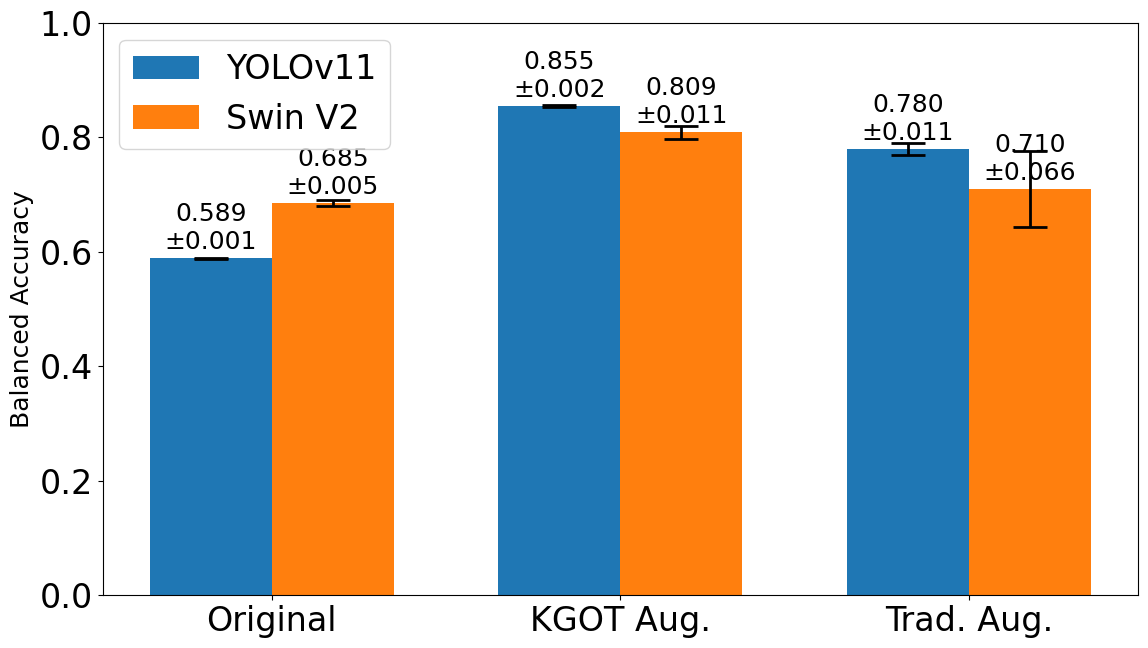

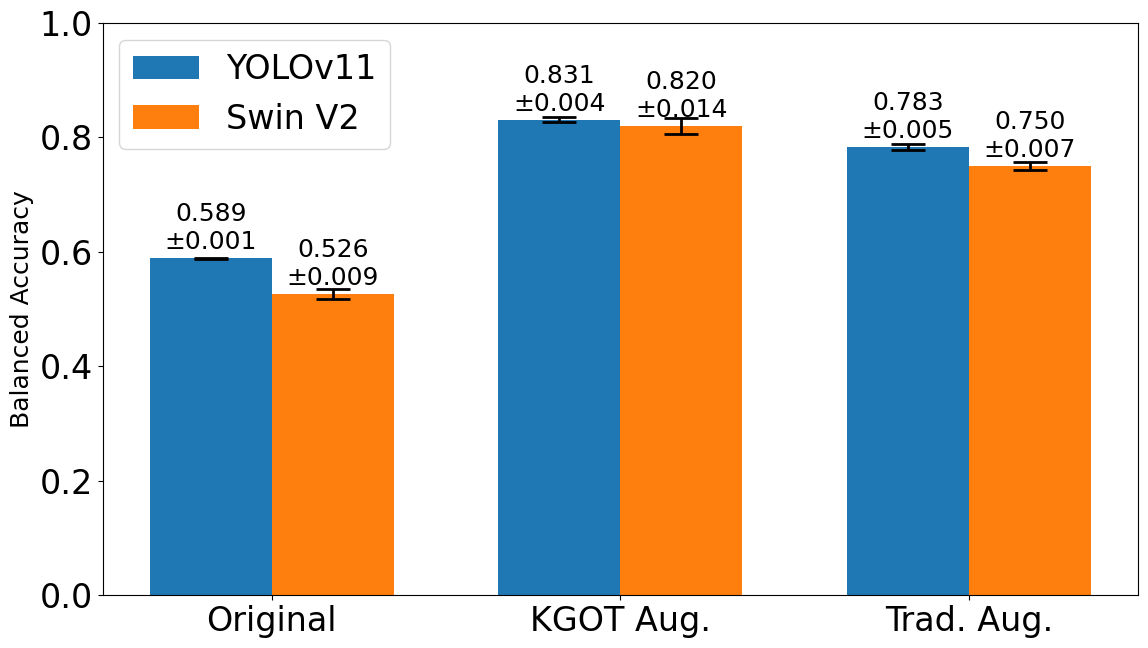

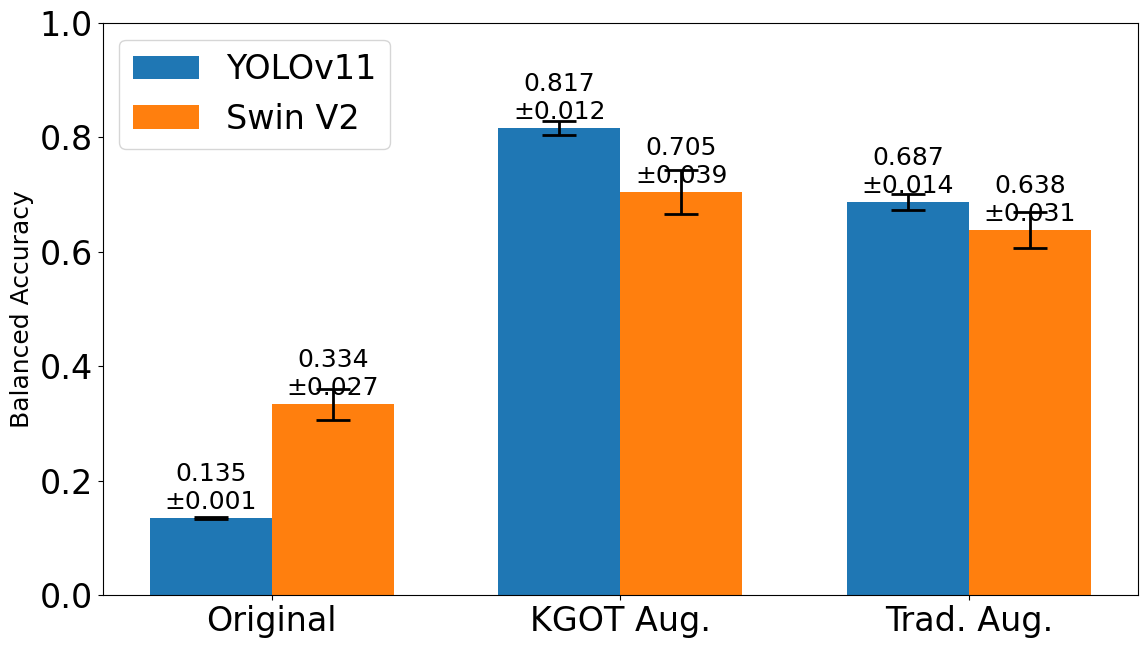

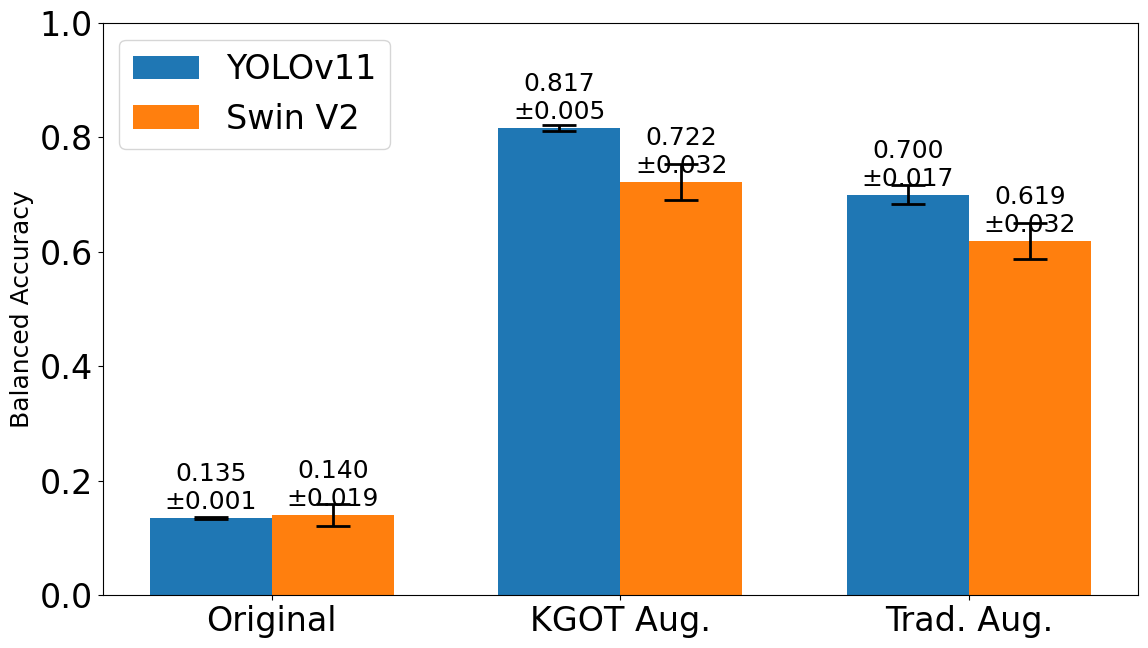

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def create_accuracy_plot(title, yolo_acc, yolo_std, swin_acc, swin_std):
    # Set font sizes
    plt.rcParams['font.size'] = 24  # Base font size
    plt.rcParams['axes.titlesize'] = 36  # Title font size
    plt.rcParams['axes.labelsize'] = 24  # Axis label font size
    plt.rcParams['xtick.labelsize'] = 24  # X-tick labels size
    plt.rcParams['ytick.labelsize'] = 24  # Y-tick labels size
    plt.rcParams['legend.fontsize'] = 24  # Legend font size

    datasets = ['Original', 'KGOT Aug.', 'Trad. Aug.']
    x = np.arange(len(datasets))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 7))
    
    rects1 = ax.bar(x - width/2, yolo_acc, width, label='YOLOv11')
    ax.errorbar(x - width/2, yolo_acc, yerr=yolo_std, fmt='none', 
               color='black', capsize=12, capthick=2, elinewidth=2)

    rects2 = ax.bar(x + width/2, swin_acc, width, label='Swin V2')
    ax.errorbar(x + width/2, swin_acc, yerr=swin_std, fmt='none', 
               color='black', capsize=12, capthick=2, elinewidth=2)

    ax.set_ylabel('Balanced Accuracy', fontsize=18)
    ax.set_title(f'{title}', fontsize=16, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.legend()

    def autolabel(rects, accuracies, stds):
        for rect, acc, std in zip(rects, accuracies, stds):
            height = rect.get_height()
            ax.annotate(f'{acc:.3f}\n±{std:.3f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom',
                       fontsize=18)  # Annotation font size

    autolabel(rects1, yolo_acc, yolo_std)
    autolabel(rects2, swin_acc, swin_std)

    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

# Unweighted Cross Entropy Loss - Regular Accuracy
create_accuracy_plot(
    '',
    yolo_acc=[0.589, 0.855, 0.780],
    yolo_std=[0.001, 0.002, 0.011],
    swin_acc=[0.685, 0.809, 0.710],
    swin_std=[0.005, 0.011, 0.066]
)

# Weighted Cross Entropy Loss - Regular Accuracy
create_accuracy_plot(
    '',
    yolo_acc=[0.589, 0.831, 0.783],
    yolo_std=[0.001, 0.004, 0.005],
    swin_acc=[0.526, 0.820, 0.750],
    swin_std=[0.009, 0.014, 0.007]
)

# Unweighted Cross Entropy Loss - Balanced Accuracy
create_accuracy_plot(
    '',
    yolo_acc=[0.135, 0.817, 0.687],
    yolo_std=[0.001, 0.012, 0.014],
    swin_acc=[0.334, 0.705, 0.638],
    swin_std=[0.027, 0.039, 0.031]
)

# Weighted Cross Entropy Loss - Balanced Accuracy
create_accuracy_plot(
    '',
    yolo_acc=[0.135, 0.817, 0.700],
    yolo_std=[0.001, 0.005, 0.017],
    swin_acc=[0.140, 0.722, 0.619],
    swin_std=[0.019, 0.032, 0.032]
)